In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

## Факторный анализ

Факторный анализ — многомерный метод, применяемый для изучения взаимосвязей между значениями переменных. Предполагается, что известные переменные зависят от меньшего количества неизвестных переменных и случайной ошибки. С помощью факторного анализа возможно выявление скрытых переменных факторов, отвечающих за наличие линейных статистических корреляций между наблюдаемыми переменными.

## Важность признака для решающего дерева

Общая важность признака в решающем дереве вычисляется следующим образом: для каждого признака рассматриваются сделанные разделения и измеряется, __насколько это разделение изменяет Gini index по отношению к вершине дерева__. Сумма вычисленных важностей приводятся к 100, тогда значение важности признака можно интерпретировать как процентный вклад в модель. 

В scikit-learn (источник: https://github.com/scikit-learn/scikit-learn/blob/0abd95f742efea826df82458458fcbc0f9dafcb2/sklearn/tree/_tree.pyx#L1056), важность узла $j$ в решающем дереве вычисляется следующим образом: $$ ni_j = w_j C_j - w_{left(j)}C_{left(j)}- w_{right(j)}C_{right(j)} $$ 
- $w_j$ взвешенное число объектов в узле  $j$
- $C_j$ impurity в данном узле
- $leaft(j)$ и $right(j)$ узлы-потомки

Важность признака $i$ вычисляется: $$ fi_i = \frac{\sum_{j : \text{node j splits on feature i}} ni_j}{\sum_{j \in \text{all nodes}} ni_j} $$

Эти значения приводятся к интервалу от 0 до 1 делением на сумму важностей признаков: $$ normfi_i = \frac{fi_i}{\sum_{j \in \text{all features}} fi_j} $$

Можно сказать, что важность признака вычисляется, как __повышение информативности в вершине, взвешенное вероятностью попадения в данную вершину__. Вероятность вершины вычисляется как доля объектов, попавших в нее. 

#### Важность признака говорит о том, какой вклад данный признак внес в повышение информативности вершин дерева. 

In [2]:
from sklearn.datasets import make_classification   
X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_classes=2)

data = pd.DataFrame()
feature_names = []
for i in range(X.shape[1]):
    data['Feature_' + str(i)] = X[:,i]
    feature_names.append('Feature_' + str(i))
data['target'] = y
data.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,target
0,0.580935,-1.239723,-0.452355,-0.787735,-1.540415,-0.087239,-0.702860,0.885165,0.886454,0.331705,0
1,-1.268949,-0.948439,0.604992,0.855278,0.700557,0.044541,0.696660,-2.811523,-0.326401,-1.486525,1
2,-1.100988,-2.095826,0.389555,0.076213,-0.379755,0.247034,-0.423096,-0.577676,0.398487,0.783281,1
3,0.111945,-1.056960,0.160158,-1.105288,-1.058290,0.664090,-0.239792,1.575131,0.864697,-0.629287,1
4,-1.964517,-1.957714,1.143475,-1.019407,1.239195,-2.156441,-0.635155,-0.131742,-1.321359,-0.956125,1


In [3]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [4]:
importance = pd.DataFrame(index=feature_names)
importance['DecisionTree'] = clf.feature_importances_

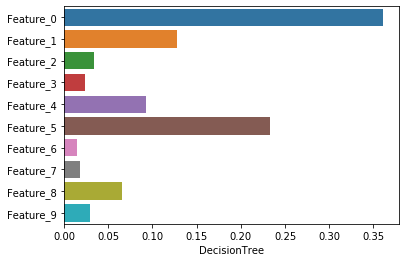

In [5]:
sns.barplot(y=importance.index, x=importance.DecisionTree)

С помощью __graphviz__ можно визуализировать построенное решающее дерево и наглядно оценить вклад каждого признака

In [6]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(clf, out_file=None, filled=True, rounded=True, feature_names=feature_names)  
graph = graphviz.Source(dot_data) 
graph.view()

'Source.gv.pdf'

### Преимущества:
- Структура дерева идеальна для __визуализации действий__ признаков в данных.
- Данные находятся в __непересекющихся группах__, которые воспринимать легче, чем цифры и точки в пространстве.
- У дерева есть __естественная визуализация__ с вершинами и ребрами.
- __Не нужно преобразовывать признаки__. Решающее дерево хорошо работает с монотонными преобразованиями.

### Недостатки:
- __Деревья не выделяют линейных закономерностей__. Любые линейные отношения между признаком и целевой переменной будет приближаться кусочно-постоянной функцией. Это не эффективно.
- К предыдущему можно добавить __недостаток гладкости__. Небольшое изменения в признаке могут иметь большое влияние на предсказание, этого обычно следует избегать.
- Деревья также довольно __нестабильны__. Небольшие изменения в данных могут создать совершенно другое дерево.
- __Число узлов быстро возрастает с глубиной__. Чем больше тупиковых вершин, тем сложнее интерпретировать алгоритм.

## Градиентный бустинг над деревьями

### - __Бустинг__ в машинном обучении - способ объединения нескольких простых моделей в ансамбль.
- Бустинг - аддитивная модель, т.к. простые модели добавляются по очереди, не изменяя уже существующие деревья в модели. Соединяя много простых моделей, можно получить мощный предсказатель в итоге.
- __Градиентный бустинг__ - термин, показывающий, что используется алгоритм градиентного спуска.

- __Решающие деревья__ используются как базовые модели. Решается задача машинного обучения по представлению данных в формате деревьев.
- Функция потерь обычно - сумма квадратов отклонений. В общем случае жн должна быть дифференцируема.


- Концепт __остатков__ в Регрессии градиентным бустингом состоит в том, что регрессор вычисляет отклонения от эелаемого результата. Далее на данном отклонении тренируется следующая простая модель. Ее вклад прибавляется к вкладу предыдущих простых моделей, что приближает к правильному предсказанию. 

### Алгоритм реализации:
1. Выбор базовой модели
2. Использование аддитивной модели
3. Определение функции потерь
4. Минимизация функции потерь

### Важность признака в ансамбле
В каждой вершине дерева увеличение критерия разделения есть значение важности, добавляемое к признаку, по которому происходит разделение. Далее важность суммируется по дереву.
https://github.com/scikit-learn/scikit-learn/blob/0abd95f742efea826df82458458fcbc0f9dafcb2/sklearn/ensemble/gradient_boosting.py#L1213). 

Конечная важность признака на уровне Градиентного Бустинга есть среднее значение по всем его деревьям. Вычисляется сумма по всем деревьям и делится на их количество:
$$ GBfi_i = \frac{\sum_{j \in \text{all trees}} normfi_j}{T} $$ где $T$ - число деревьев.

In [7]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [8]:
importance['XGBoost'] = clf.feature_importances_
importance

,DecisionTree,XGBoost
Feature_0,0.360694,0.294207
Feature_1,0.127935,0.137029
Feature_2,0.034096,0.032822
Feature_3,0.023376,0.022801
Feature_4,0.092912,0.165766
Feature_5,0.232895,0.163447
Feature_6,0.014681,0.021856
Feature_7,0.018331,0.028448
Feature_8,0.065718,0.097094
Feature_9,0.029362,0.036531


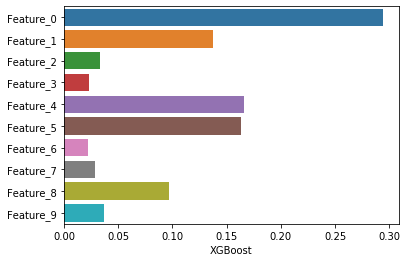

In [9]:
sns.barplot(y=importance.index, x=importance.XGBoost)

### Преимущества:
- __Лучше точность__: по сравнению с другими техниками регрессии, такими как Линейная Регрессия, бустинг практически всегда выигрывает.
- __Меньше препроцессинга__: бустинг требует минимальной предобработки данных, что помогает реализовывать можель с меньшей сложностью.
- __Большая гибкость__: бустинг может быть реализован с большим числом гиперпараметров и функций потерь и поэтому использоваться для широкого класса задач.
- __Пропуски в данных__: бустинг сам справляется с пропусками в данных.

## Permutation Feature Importance

- Permutation feature importance (PFI) измеряет повышение ошибки предсказания после перестановки значений признаков, то есть изменения взаимодействия между признаком и выходом.
- Признак считается __важным__, если перестановка его значения повышает ощибку модели, потому что модель сильно полагается на его вклад. __Неважный__ - признак, перестановка которого оставляет модель неизменной, то есть который она игнорирует в предсказании.

__Алгоритм PFI основан на  Fisher, Rudin, and Dominici (2018):__

Вход: обученная модель $f$, матрица признаков $X$, целевой вектор $y$, функция ошибки $L(y,f)$
1. Оценивается ошибка оригинальной модели $e^{orig} = L(y, f(X))$ (например, MSE)
2. Для каждого признака$j = 1,…,p$:
    - Создается матрица признака $X^{perm}$ перестановкой признака $j$ в данных $X$. Это разрушает коррелляцию между признаком $j$ и выходом $y$
    - Оценивается ошибка $e^{perm} = L(Y,f(X^{perm}))$ основываясь на предсказаниях перестановочных данных.
    - Вычисляется PFI $FI_j = \frac{e^{perm}}{e^{orig}}$. Альтернативно может быть использована разница: $FI_j = e^{perm} - e^{orig}$
3. Признаки сортируются по убыванию $FI$

### Связь с важностью по информативности
- Модели, основанные на деревьях, предполагают использование важностей, основанных на среднем повышении информативности (MDI). Такая важность может быть __не реперезентативной для новых данных__. Для перестановок эта проблема неактуальна.
- Более того, важность, основанная на информативности сильно __смещена__ и склоняется к признакам с большим множеством значений (числовые признаки)
- Также информативная важность вычисляется только по статистикам, вычисленным на обучающих данных, и поэтому на нее влияет __переобучение__.
- Перестановочная важность может также использовать __дополнительные метрики__ на предсказаниях дерева.

In [10]:
from eli5.sklearn import PermutationImportance
from eli5 import explain_weights_df

perm = PermutationImportance(clf)
perm.fit(X, y)
result = explain_weights_df(perm, feature_names=feature_names).sort_values(by='feature')
importance['Permutation'] = result['weight'].values
importance

/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


,DecisionTree,XGBoost,Permutation
Feature_0,0.360694,0.294207,0.1346
Feature_1,0.127935,0.137029,0.0774
Feature_2,0.034096,0.032822,0.0118
Feature_3,0.023376,0.022801,0.0020
Feature_4,0.092912,0.165766,0.1776
Feature_5,0.232895,0.163447,0.2380
Feature_6,0.014681,0.021856,0.0032
Feature_7,0.018331,0.028448,0.0058
Feature_8,0.065718,0.097094,0.0120
Feature_9,0.029362,0.036531,0.0098


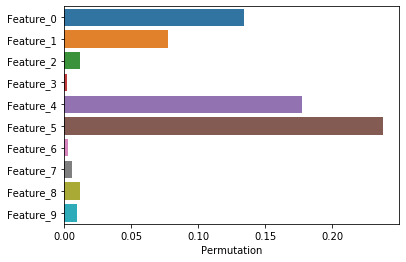

In [11]:
sns.barplot(y=importance.index, x=importance.Permutation)

### Преимущества:
- __Хорошая интерпретация__: Важность признака есть повышение ошибки модели в отсутствие информации от данного признка.
- Такая важность представляет __сжатый, глобальный инсайд__ в поведение модели.
- Использование доли ошибок вместо разности позволяет делать меру важности __сравнимой для разных задач__.
- Перестановочная важность автоматически учитывает __отношение с другими признаками__.
- __Не требуется обучать модель заново__.

### Недостатки:
- __Непонятно, использовать обучение или тест__ для вычисления важности признаков.
- __Связь с ошибками модели__.
- Необходим __доступ к y_train__
- Используются перестановки, а значит, влияет случайность, поэтому __результаты могут быть разными__. Усреднение же по многим перестановкам сильно увеличивает время.
- Если признаки корреллируют, на важность __могут повлиять нереалистичные объекты в данных__.

## Shapley Values

- Предсказание может быть объяснено предположением, что каждое значение объекта выборки - "игрок", а предсказание - его результат. Метод Шепли - метод из теории игр, объясняющий, как правильно распределять "выигрыш" между игроками.
- __Игра__ есть задача предсказания для обного объекта в данных. __Прирост__ есть действительное предсказание для данного объекта за вычетом среднего для всех объектов. __Игроки__ есть значения признаков для объектов, стремящиеся получить прирост.
- Значения Шепли есть средний прирост признака по всем возможным коалициям.
- Значения Шепли работают для классификации(если используются вероятности) и регрессии.

### Вычисление:
Индекс Шепли определяется значением $val$ игроков в  $S$. Индекс Шепли для признака есть его вклад в выигрыш, взвешенный и просуммированный по всевозможным комбинациям данных.
$$ \phi_j(val)=\sum_{S\subseteq\{x_{1},\ldots,x_{p}\}\setminus\{x_j\}}\frac{|S|!\left(p-|S|-1\right)!}{p!}\left(val\left(S\cup\{x_j\}\right)-val(S)\right) $$
- $S$ подмножество признаков модели
- $x$ вектор значения признаков объекта
- $p$ число признаков
- $val_x(S)$ предсказание значений признаков в множестве $S$, маргинализованные по признакам, не включенным в $S$:
$$ val_{x}(S)=\int\hat{f}(x_{1},\ldots,x_{p})d\mathbb{P}_{x\notin{}S}-E_X(\hat{f}(X)) $$

## Недостаток
состоит в том, что вычисление индексов Шепли требует __большого объема вычислений__. В 99.9% случаев используется приближенное решение.

### SHAP (SHapley Additive exPlanations)

- SHAP (Lundberg, Lee) - метод для объяснения индивидуальных предсказаний, основанный на индексе Шепли.
- Авторы предлагают __KernelSHAP__, ядерный подход, вдохновленный LIME и TreeSHAP, эффективная оценка для моделей, основанных на деревьях.
- Цель SHAP - объяснить предсказание для объекта путем вычисления вклада каждого признака в предсказание.
- Инновация, внесенная SHAP - представление индекса Шепли аддитивным методом, линейной моделью. Этот подход __объединяет LIME и Индексы Шепли__.

__Коротко о локальных суррогатах (LIME):__
- Это интерпретируемы модели для объяснения индивидуальных предсказаний моделей машинного обучения как черных ящиков. Они описаны в статье, где авторы предлагают конкретную реализацию модели. Суррогатные модели используются для приближения предсказаний оригинального черного ящика. Вместо обучения глобальной модели - суррогата, LIME концентрируется на обучении локальных моделей для объяснения индивидуальных предсказаний.
- Идея довольно интуитивна: LIME тестирует, что происходит, с предсказаниями с отклонениями при подаче их в оригинальную модель. Создается новый датасет, состоящий из данных с перестановками и соответствующих предсказаний для черного ящика. На этом датасете тренируется интерпретируемая модель, которая взвешивается соответственно вероятности появления данного объекта в данных. Такая модель является хорошим локальным приближением. но не глобальным. Такая точность называется __local fidelity__.
- Математически, локальные суррогаты могут быть представлены следующим образом:  $$ \text{explanation}(x)=\arg\min_{g\in{}G}L(f,g,\pi_x)+\Omega(g) $$ 
    - Объясняющая модель для объекта $x$ есть модель $g$ минимизирующая функцию потерь $L$, измеряющую, как близко предсказание к таковому у оригинальной модели $f$, когда сложность $\Omega(g)$ удерживается низкой.
    - $G$ есть семейство возможных объяснений 
    - Мера вероятности $\pi_x$ определяет, насколько большую окрестность $x$ мы рассматриваем для объяснения.

### LIME + Shapley Values = SHAP
SHAP выделяет следующее объсянение: $$ g(z')=\phi_0+\sum_{j=1}^M\phi_jz_j' $$
- $g$ объясняющая модель
- $z'\in\{0,1\}^M$ вектор коалиции/упрощенные признаки, где 1 значит, что соответствующий признак присутствует, 0 в обратном случае.
- $M$ есть максимальный размер коалиции
- $\phi_j\in\mathbb{R}$ есть вес признака $j$, индекс Шепли


Для $x$, исследуемого объекта, вектор коалиции $x’$есть вектор из всех единиц, то есть все признаки присутствуют. В таком случае формула выглядит следующим образом: $$ g(x')=\phi_0+\sum_{j=1}^M\phi_j $$

### KernelSHAP
KernelSHAP оценивает для объекта $x$ вклад каждого признака в предсказание. KernelSHAP consists of __5 steps__:
1. Пример коалиции $z_k'\in\{0,1\}^M, k\in\{1,\ldots,K\}$ (1 = признак присутствует в коалиции, 0 = признак отсутствует)

    - Случайная коалиция может быть создана подбрасыванием монетки.
    - К созданных коалиций становятся датасетом для обучаемой модели. Целевая переменная - предсказание коалиции.


2. Берется предсказание $z_k'$ сначала преобразуя $z_k'$ к оригинальному признаковому пространству а затем применяя модель $f$: $f(h_x(z_k'))$

    - Чтобы из коалиций получить корректные значения признаков, требуется фенкция $h_x(z')=z$ где $h_x:\{0,1\}^M\rightarrow\mathbb{R}^p$. Функция $h_x$ ставит коалиции корректный объект. 

3. Вычисляется вес для каждого $z_k'$ ядром SHAP

    - __Большое отличие от LIME__ во взвешивании объектов регрессионной модели.
    
4. Обучение регрессионной модели:
    $$ g(z')=\phi_0+\sum_{j=1}^M\phi_jz_j' $$
    - Обучается регрессионная модель $g$ оптимизацией функции потерь $L$: $$ L(f,g,\pi_{x})=\sum_{z'\in{}Z}[f(h_x(z'))-g(z')]^2\pi_{x}(z') $$ где $Z$ - обучающая выборка. Обычно оптимизируется MSE.


5. Возвращаются индексы Шепли $\phi_j$, вычисленные коэффициенты для регрессионной модели.



In [12]:
import shap

explainer = shap.KernelExplainer(clf.predict, X)


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
%%time
data_for_prediction = X[0:20]
shap_values = explainer.shap_values(data_for_prediction)
expected_value = explainer.expected_value
shap.initjs()

importance['KernelShap'] = shap_values.mean(axis=0)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [ ]:
shap.summary_plot(shap_values, data_for_prediction, plot_type='bar', 
                             feature_names=feature_names)

In [ ]:
shap.force_plot(expected_value, shap_values, data_for_prediction, 
                           feature_names=feature_names)

### TreeSHAP
- TreeSHAP - вариация shap для алгоритмов, основанных на деревьях. TreeSHAP быстрее, вычисляет точные индексы Шепли и точно их оценивает, когда есть коррелляции между признаками.
- Для точных индексов Шепли вычислительная сложность снижена с экспоненциальной $O(TL2^M)$ к полиномиальной $O(TLD)^2$, где $T$ число деревьев, $L$ максимальное число листьев а $D$ максимальная глубина дерева.
- TreeSHAP оценивает корректное условное матожидание $E_{X_S|X_C}(f(x)|x_S)$
- Вычисление может быть расширено на другие деревья: благодаря свойству аддитивности индексов Шепли, __Индексы Шепли ансамбля деревьев есть усредненные индексы для индивидуальных деревьев.__

In [ ]:
explainer = shap.TreeExplainer(clf, X)

In [ ]:
%%time
data_for_prediction = X[0:20]
shap_values = explainer.shap_values(data_for_prediction)
expected_value = explainer.expected_value
shap.initjs()

importance['TreeShap'] = shap_values.mean(axis=0)

### SHAP Важность признаков
Идея в том, что у признаков с большим значением индекса Шепли более важны. Поскольку необходима глобальная интерпретабельность, мы усредняем абсолютные значения индексов Шепли по данным. Далее, признаки сортируются по убыванию важности для отобржения.

In [ ]:
shap.summary_plot(shap_values, data_for_prediction, plot_type='bar', 
                             feature_names=feature_names)

### Преимущества:
- Так как в SHAP участвуют индексы Шепли, есть и все их преимущества: __теоретическое обоснование__ из теории игр, предсказание __честно распределено__ по признакам, предсказания позволяют сравнивать признаки со средним предсказанием.
- SHAP __соединяет LIME и индексы Шепли__
- SHAP __имеет быструю имплементацию__ для моделей, основанных на деревьях
- Быстрое вычисление позволяет вычислять необходимые индексы Шепли для __глобальной интерпретабельности__, включающей методы для важности признаков, взаимодействии и зависимостях и графиков.

### Недостатки:
- __KernelSHAP медленный__, что делает его непрактичным для вычисления индексов Шепли для многих объектов.
- __KernelSHAP Игнорирует зависимости признаков__. Это можно обойти, заменяя признаки на случайные из распределений, однако это создает новую зависимость от случайно выбираемых точек. Проблема решается TreeSHAP.
- Распространяются также и недостатки индексов Шепли: возможность __неверной интерпретации__ и __необходимость доступа к данным__ для пересчета на новые данные.

In [ ]:
importance

### Были рассмотрены методы факторного анализа для деревьев,  ансамблей, методы Permutation Importance, Shapley values, LIME, SHAP.
области применимости методов различны, выбор следует осуществлять в зависимости от поставленной задачи

In [ ]:
plt.barplot(importance.index, importance.XGBoost)